## Imports and setup

In [332]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

from matplotlib.colors import hsv_to_rgb
import colorsys

In [3]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

## Load img

In [290]:
path = 'wall_pics/wall1.png'
img = cv.imread(path, cv.IMREAD_UNCHANGED)
orig = img.copy()
RGB_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

## Look at original image

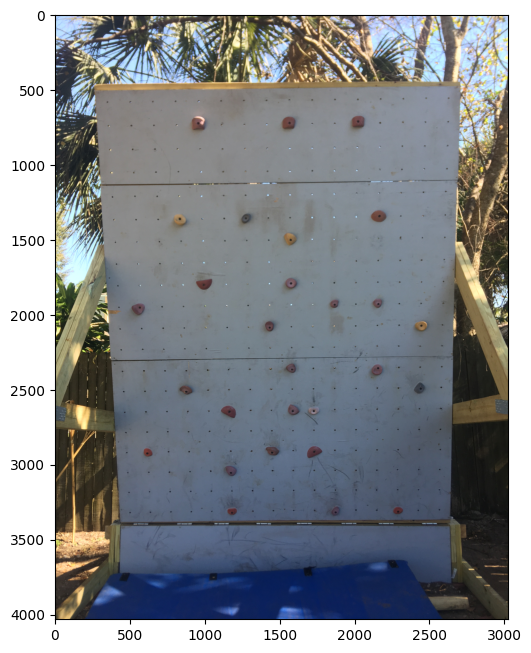

In [292]:
plt.imshow(RGB_img)

## Apply bilateral filter to smooth out image

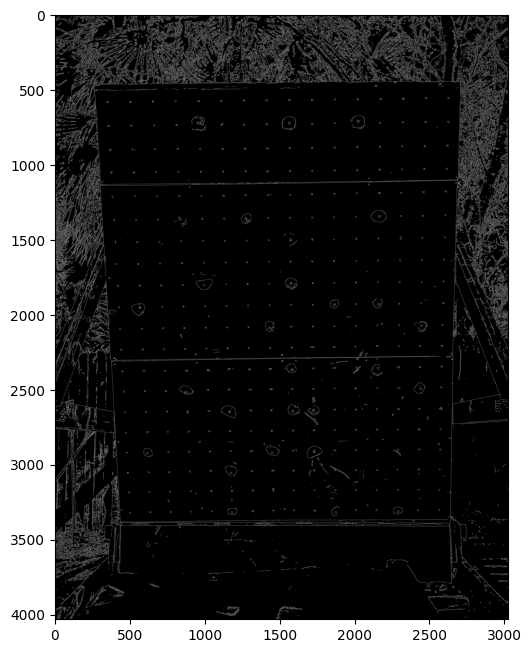

In [294]:
img_blur = cv.bilateralFilter(gray, 11, 17, 17)
low_thresh = 30
hi_thresh = 25
# ratio = 10
# hi_thresh = low_thresh * ratio
edged = cv.Canny(img_blur, low_thresh, hi_thresh)

plt.imshow(edged, cmap='gray')

## Get threshold image (don't remember why this helps)

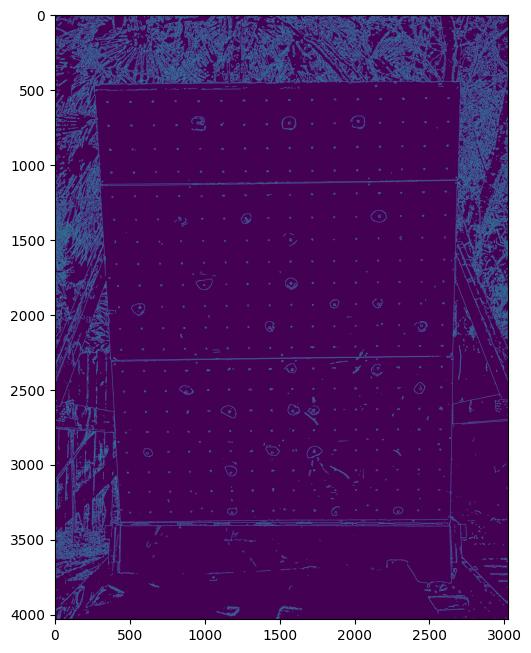

In [295]:
img_grey = edged
#set a thresh
thresh = 100
#get threshold image
ret,thresh_img = cv.threshold(img_grey, thresh, 255, cv.THRESH_BINARY)
# display thresh img
plt.imshow(thresh_img)

## find contours in image

In [296]:
# inp = edged
inp = thresh_img

#find contours
contours, hierarchy = cv.findContours(inp, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

#create an empty image for contours
img_contours = np.zeros(img.shape, dtype=np.uint8)

(4032, 3024, 3)


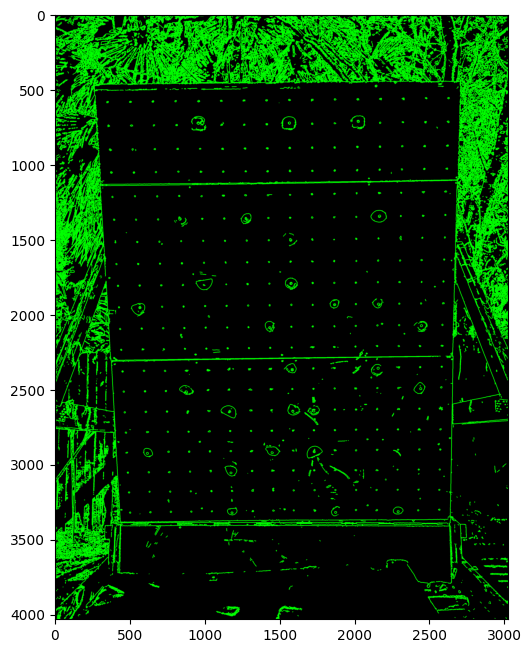

In [297]:
# draw the contours on the empty image
cv.drawContours(img_contours, contours, -1, (0,255,0), 3)
plt.imshow(img_contours)
print(img_contours.shape)

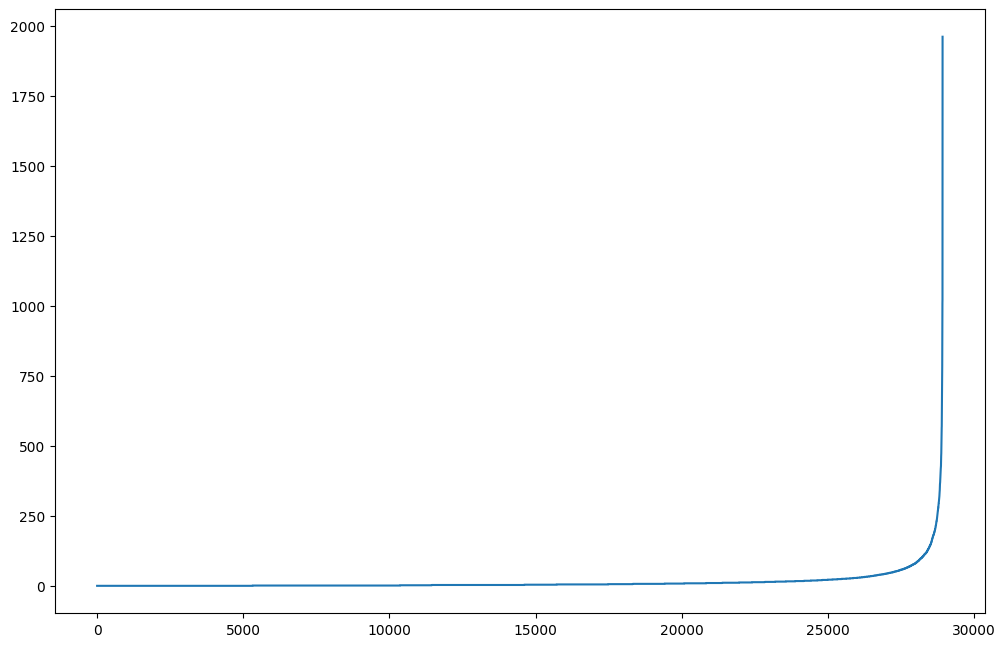

In [298]:
num_pts_per_cnt = [cnt.shape[0] for cnt in contours]
num_pts_per_cnt.sort()
plt.plot(num_pts_per_cnt)

In [299]:
# get strongest contours
num = 500
strongest_contours = sorted(contours, key=cv.contourArea, reverse=True)[:num]

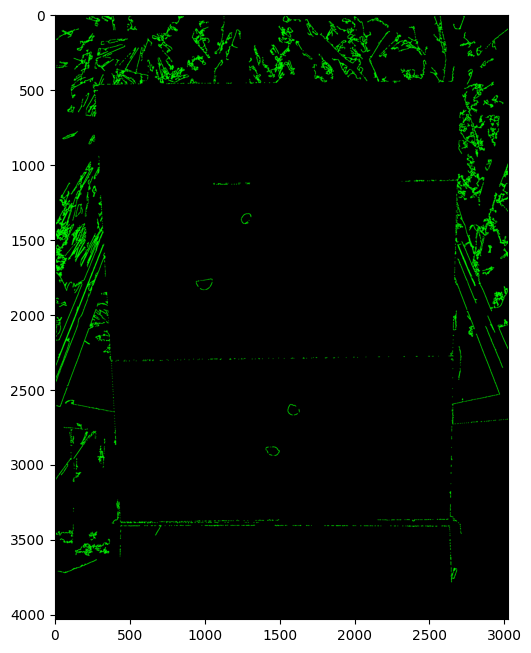

In [300]:
upper = 1000000
lower = 200
img_cnts = np.zeros(orig.shape, dtype=np.uint8)

for cnt in contours:
    if lower < cnt.shape[0] < upper:
        cv.drawContours(img_cnts, cnt, -1, (0,255,0), 3)
plt.imshow(img_cnts)

In [301]:
# # for i, cnt in enumerate(strongest_contours):
# for i, cnt in reversed(list(enumerate(strongest_contours))):
#     if i == num-10:
#         break
#     plt.figure()
    
#     #create an empty image for contours
#     img_cnts = np.zeros(orig.shape, dtype=np.uint8)
    
#     cv.drawContours(img_cnts, cnt, -1, (0,255,0), 3)
#     plt.imshow(img_cnts)

# # cv.drawContours(img_cnts, strongest_contours, -1, (0,255,0), 3)
# # plt.imshow(img_cnts)

## Detect corners of wall

[[[2814. 1067.]]

 [[2794.  981.]]

 [[2878.  938.]]

 [[2436.  127.]]]


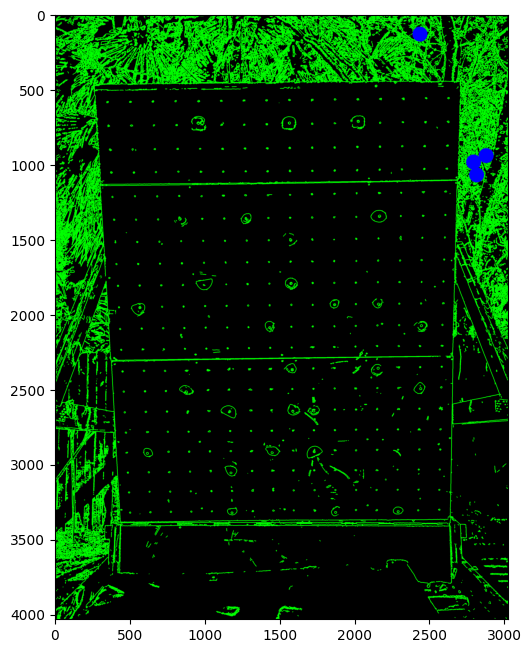

In [302]:
img_corners = np.array(img_contours, dtype=np.uint8)
gray = cv.cvtColor(img_corners, cv.COLOR_BGR2GRAY)
canny = cv.Canny(gray, 120, 255, 1)
corners = cv.goodFeaturesToTrack(canny,4,0.5,50)

for corner in corners:
    x,y = corner.ravel()
    cv.circle(img_corners,(x,y),50,(0,0,255),-1)

print(corners)
    
plt.imshow(img_corners)

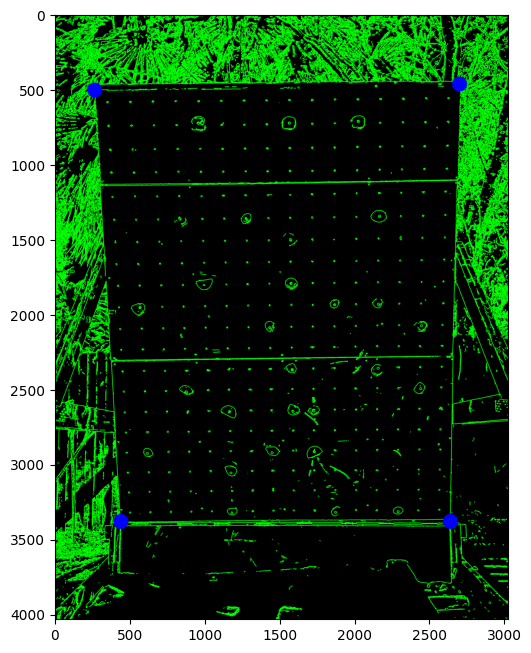

In [316]:
img_corners_bf = np.array(img_contours, dtype=np.uint8)

# ul, ur, ll, lr
bf_corners1 = np.array([
    [[265, 500]],
    [[2700, 460]],
    [[440, 3380]],
    [[2640, 3380]],
])
bf_corners = bf_corners1
for corner in bf_corners:
    x,y = corner.ravel()
    cv.circle(img_corners_bf,(x,y),50,(0,0,255),-1)
    
plt.imshow(img_corners_bf)

## Straighten image (https://stackoverflow.com/questions/41995916/opencv-straighten-an-image-with-python)

[[ 265  500]
 [2700  460]
 [ 440 3380]
 [2640 3380]]
2700
3380
(4032, 3024, 3)


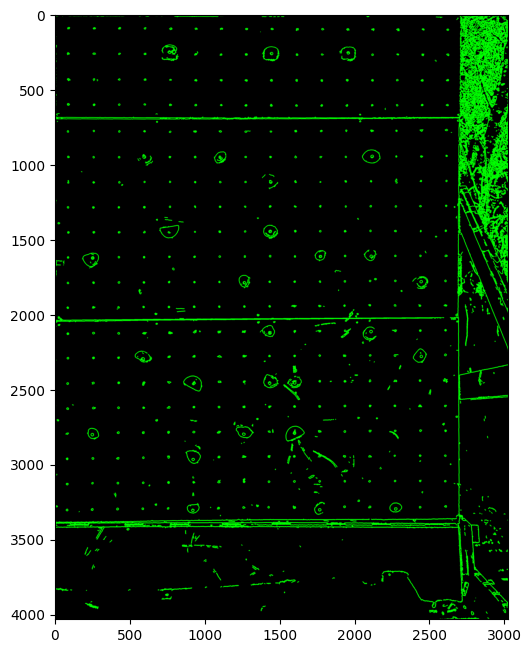

In [304]:
#---- 4 corner points of the bounding box
pts_src = np.array([pt.ravel() for pt in bf_corners])
print(pts_src)

#---- 4 corner points of the black image you want to impose it on
dx = pts_src[1][0]
print(dx)
dy = pts_src[2][1]
print(dy)
pts_dst = np.array([[0.0,0.0], [dx,0.0], [0.0,dy],[dx, dy]])

#---- forming the black image of specific size
im_dst = np.zeros(img_contours.shape, np.uint8)

#---- Framing the homography matrix
h, status = cv.findHomography(pts_src, pts_dst)

#---- transforming the image bound in the rectangle to straighten
im_out = cv.warpPerspective(img_contours, h, (im_dst.shape[1],im_dst.shape[0]))
# cv2.imwrite("im_out.jpg", im_out)

plt.imshow(im_out)

print(im_out.shape)

## Crop image

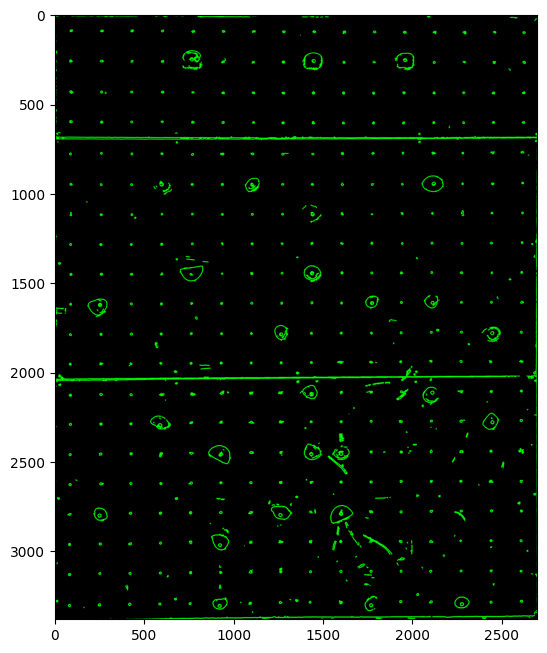

In [305]:
crop_img = im_out[:dy, :dx]
plt.imshow(crop_img)

## Transform/crop original image based on corners of wall

[[ 265  500]
 [2700  460]
 [ 440 3380]
 [2640 3380]]


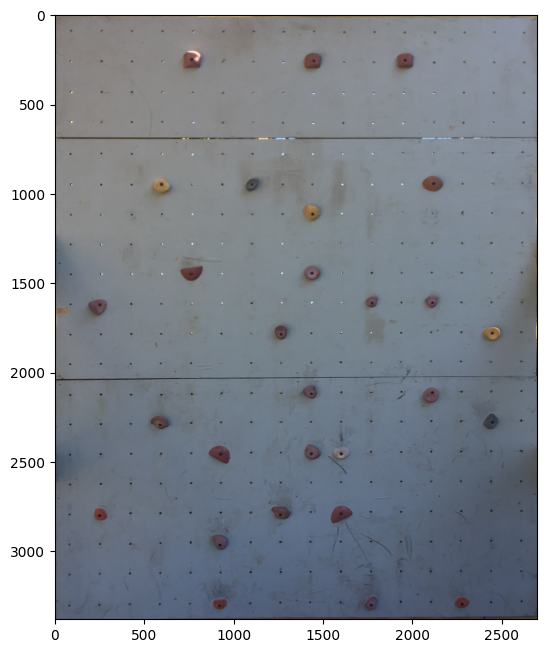

In [306]:
#---- 4 corner points of the bounding box
pts_src = np.array([pt.ravel() for pt in bf_corners])
print(pts_src)

#---- 4 corner points of the black image you want to impose it on
dx = pts_src[1][0]
dy = pts_src[2][1]
pts_dst = np.array([[0.0,0.0], [dx,0.0], [0.0,dy],[dx, dy]])

#---- forming the black image of specific size
im_dst = np.zeros(RGB_img.shape, np.uint8)

#---- Framing the homography matrix
h, status = cv.findHomography(pts_src, pts_dst)

#---- transforming the image bound in the rectangle to straighten
orig_warped = cv.warpPerspective(RGB_img, h, (im_dst.shape[1],im_dst.shape[0]))
crop_img = orig_warped[:dy, :dx]

plt.imshow(crop_img)

## Detect corners of wall by color

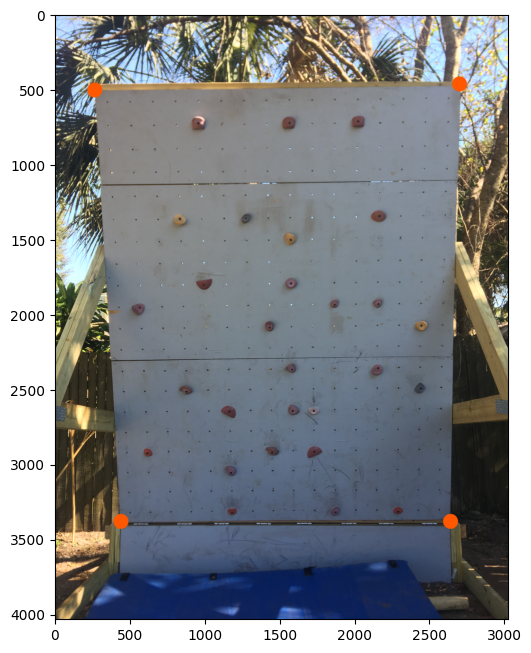

In [307]:
path = 'wall_pics/wall.png'
raw = cv.imread(path, cv.IMREAD_UNCHANGED)
raw = cv.cvtColor(raw, cv.COLOR_BGR2RGB)

for corner in bf_corners:
    x,y = corner.ravel()
    cv.circle(raw,(x,y),50,(255,88,0),-1)
    
plt.imshow(raw)

## Filter img by color (https://realpython.com/python-opencv-color-spaces/)

(14.666666666666666, 255, 255)


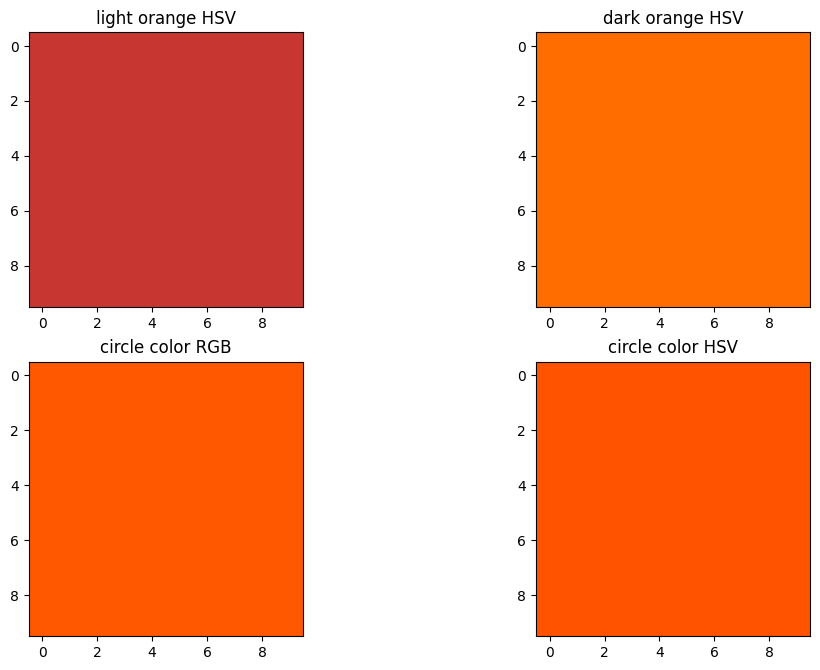

In [315]:
def show_color(color, is_hsv=True, title=""):
    square = np.full((10, 10, 3), color, dtype=np.uint8) / 255.0 
    if is_hsv:
        plt.imshow(hsv_to_rgb(square))
    else:
        plt.imshow(square)
    plt.title(title)

rgb_circle_color = (255,88,0)

hsv_cc = colorsys.rgb_to_hsv(1, 88/255., 0)
hsv_cc = (hsv_cc[0]*255,hsv_cc[2]*255,hsv_cc[2]*255)
print(hsv_cc)

# Convert BGR to HSV
hsv = cv.cvtColor(raw, cv.COLOR_RGB2HSV)
light_orange = (1, 190, 200) # hsv
dark_orange = (18, 255, 255) # hsv

plt.subplot(2,2,1)
show_color(light_orange, title="light orange HSV")
plt.subplot(2,2,2)
show_color(dark_orange, title="dark orange HSV")
plt.subplot(2,2,3)
show_color(rgb_circle_color, is_hsv=False, title="circle color RGB")
plt.subplot(2,2,4)
show_color(hsv_cc, title="circle color HSV")
plt.show()

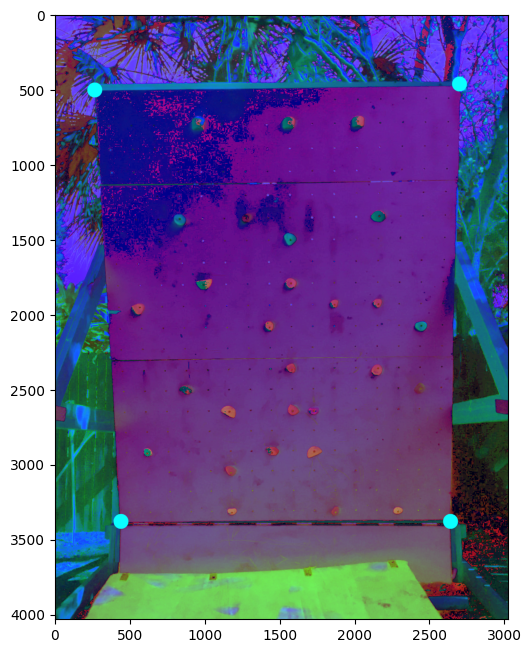

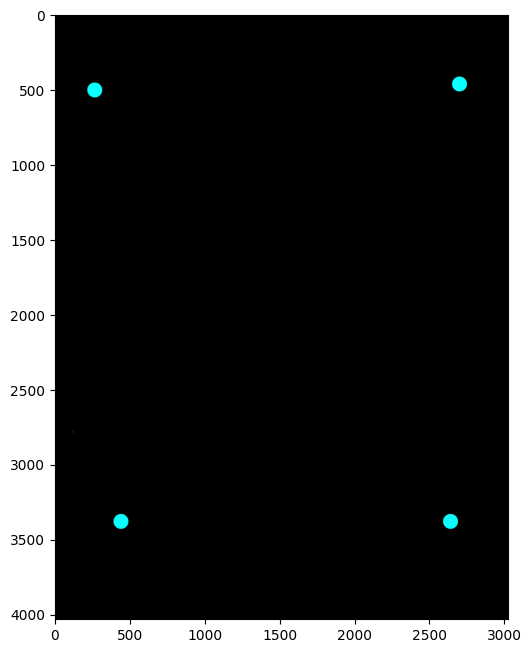

In [309]:
plt.imshow(hsv)
plt.show()

# Threshold the HSV image to get only orange colors
mask = cv.inRange(hsv, light_orange, dark_orange)
result = cv.bitwise_and(hsv, hsv, mask=mask)
plt.imshow(result)

## Get centroid of circles at corners of wall (https://www.pyimagesearch.com/2014/07/21/detecting-circles-images-using-opencv-hough-circles/)

[[ 268  500   53]
 [ 440 3376   52]
 [2638 3376   53]
 [2698  464   46]]


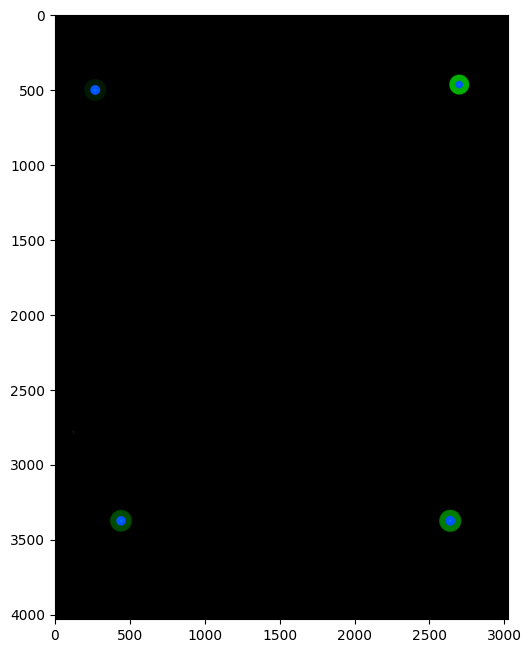

In [310]:
# convert the image to grayscale
bgr = cv.cvtColor(result, cv.COLOR_HSV2BGR)
output = bgr.copy()
gray = cv.cvtColor(bgr, cv.COLOR_BGR2GRAY)

# squeeze to remove single dimensional nested list
circles = np.squeeze(cv.HoughCircles(gray, cv.HOUGH_GRADIENT, 3, 100))

# ensure at least some circles were found
if circles is not None:
    # sort by first column as keys
    circles = circles[circles[:,0].argsort()]
    
    # convert the (x, y) coordinates and radius of the circles to integers
    circles = np.round(circles).astype("int")
    
    print(circles)
    
    sec = 25
    # loop over the (x, y) coordinates and radius of the circles
    for (x, y, r) in circles:
        # draw the circle in the output image, then draw a rectangle
        # corresponding to the center of the circle
        cv.circle(output, (x, y), r, (0, sec, 0), 40)
        sec += 50
        cv.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
    # show the output image
    
    plt.imshow(output)
    plt.show()
else:
    print("circles is None")

## Transform image based on detected centroids

In [311]:
## brute force pts_src
# [[ 265  500]
#  [2700  460]
#  [ 440 3380]
#  [2640 3380]]

## detected pts_src
# [[ 268  500]
#  [ 440 3376]
#  [2638 3376]
#  [2698  464]]

## constructed pts_dest
# [[   0.    0.]
#  [   0. 3380.]
#  [2700.    0.]
#  [2700. 3380.]]

# TODO: find a way to make pts_src align with pts_dest
Just need to index properly, do four corners explicitly or somethin

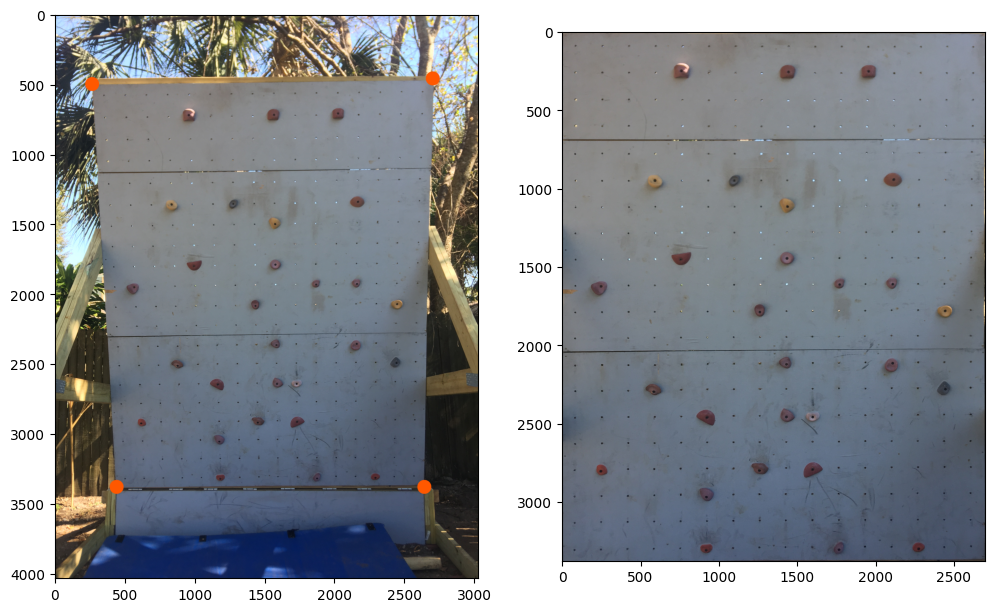

In [312]:
#---- 4 corner points of the bounding box
pts_src = np.array([pt[:2] for pt in circles])
pts_src[[1,3]] = pts_src[[3,1]]
pts_src[[2,3]] = pts_src[[3,2]]

#---- 4 corner points of the black image you want to impose it on
dx = pts_src[1][0]
dy = pts_src[2][1]
pts_dst = np.array([[0.0,0.0], [dx,0.0], [0.0,dy], [dx, dy]])

#---- forming the black image of specific size
im_dst = np.zeros(raw.shape, np.uint8)

#---- Framing the homography matrix
h, status = cv.findHomography(pts_src, pts_dst)

#---- transforming the image bound in the rectangle to straighten
orig_warped = cv.warpPerspective(RGB_img, h, (im_dst.shape[1],im_dst.shape[0]))
crop_img = orig_warped[:dy, :dx]

plt.subplot(1,2,1)
plt.imshow(raw)
plt.subplot(1,2,2)
plt.imshow(crop_img)

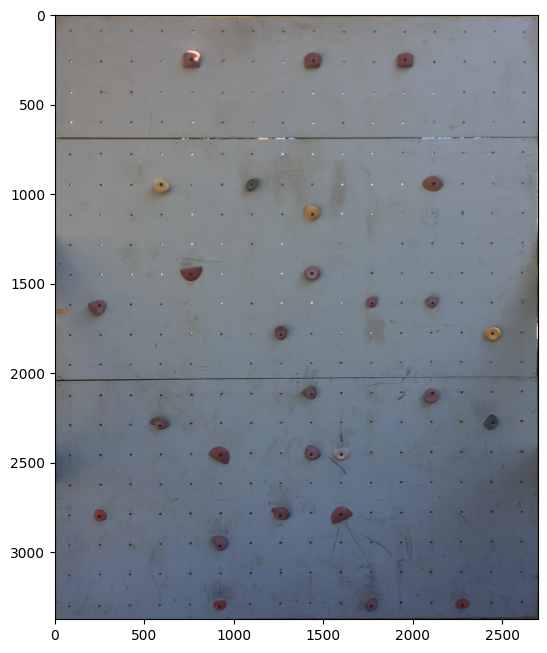

In [313]:
plt.imshow(crop_img) 

## Reduce dimension to a standard size for extracting holds

(3376, 2698, 3)
(1200, 900, 3)


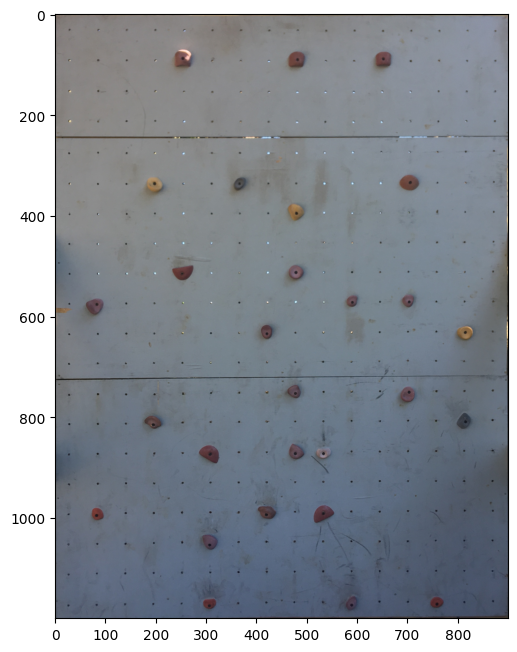

In [331]:
print(crop_img.shape)
height = 1200
width=900

# Opens a image in RGB mode
im = Image.fromarray(crop_img)

resized = im.resize((width,height))
open_cv_resized = np.array(resized) 
# Convert RGB to BGR 
img = open_cv_resized[:, :, ::-1].copy() 
print(img.shape)
plt.imshow(resized)